### Import Libraries

In [ ]:
pip install imbalanced-learn transformers torch scikit-learn

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Read the test and train dataset from the checkpoint

In [40]:
train_df = pd.read_csv("../data/train_dataset_w56types.csv")

In [41]:
train_df.shape

(7222, 12)

## Data Preprocessing

In [42]:
# Get unique count of values in each column
unique_counts = train_df.apply(lambda x: x.nunique())
print("\nUnique Value Counts:")
print(unique_counts)


Unique Value Counts:
project_name                             7160
methodology_or_protocol                   339
fully_harmonized_methodology_protocol     275
version_string                             13
region                                     13
voluntary_registry                          4
project_type_from_the_registry            100
project_developer                        2561
arborwaproject                              4
scope                                       8
type                                       56
rule_based_type_mapping_first              65
dtype: int64


In [43]:
train_df.head(15)

,project_name,methodology_or_protocol,fully_harmonized_methodology_protocol,version_string,region,voluntary_registry,project_type_from_the_registry,project_developer,arborwaproject,scope,type,rule_based_type_mapping_first
0,Fessenden Dairy,,ARB Compliance Offset Protocol: Capturing and ...,,North America,CAR,Livestock Gas Capture/Combustion,Environmental Credit Corp.,Early Action,Agriculture,Manure Methane Digester,Manure Methane Digester
1,Solar Power Project by Fortum FinnSurya Energy...,ACM0002 Grid-connected electricity generation ...,ACM0002 Grid-connected electricity generation ...,,Southern Asia,GOLD,Solar Thermal - Electricity,Fortum India Private Limited,No,Renewable Energy,Solar - Centralized,Solar - Distributed
2,Biomass based Renewable Energy Generation at K...,AMS-I.C.,AMS-I.C. Thermal energy production with or wit...,,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,Modern Dairies Limited,No,Renewable Energy,Biomass,
3,Demircili WPP,ACM0002 Grid-connected electricity generation ...,ACM0002 Grid-connected electricity generation ...,,Western Asia,GOLD,Wind,GTE KARBON SUSTAINABLE ENERJI EGITIM DANISMAN...,No,Renewable Energy,Wind,Wind
4,Corinth Abandoned Mine Methane Recovery Project,VMR0002,ARB Compliance Offset Protocol: Mine Methane C...,,North America,VCS,Energy industries (renewable/non-renewable sou...,"Keyrock Energy, LLC",Early Action,Industrial & Commercial,Mine Methane Capture,Mine Methane Capture
5,Protection of the Amazon Rain Forest II,VM0007,VM0007 REDD+ Methodology Framework (REDD-MF),,Latin America and the Caribbean,VCS,Agriculture Forestry and Other Land Use,Redd Services,No,Forestry & Land Use,REDD+,
6,Jbel Sendouq-Khalladi (“Khalladi”) wind farm p...,ACM0002 Grid-connected electricity generation ...,ACM0002 Grid-connected electricity generation ...,,Northern Africa,GOLD,Wind,ACWA Khalladi,No,Renewable Energy,Wind,Wind
7,Foam Blowing Agent 001,Transition to Advanced Formulation Blowing Age...,ACR Transition to Advanced Formulation Blowing...,,North America,ACR,Industrial Process Emissions,297,No,Chemical Processes,HFC Replacement in Foam Production,HFC Replacement in Foam Production
8,"Umut-I Hydropower Plant, Turkey",AMS-I.D.,AMS-I.D. Grid connected renewable electricity ...,,Western Asia,VCS,Energy industries (renewable/non-renewable sou...,RHG Enerturk Enerji Uretim ve Tic. A.S.,No,Renewable Energy,Hydropower,Hydropower
9,Muyuan Ongniud Banner AWMS GHG Mitigation Proj...,ACM0010,ACM0010 GHG emission reductions from manure ma...,,Eastern Asia,VCS,"Livestock, enteric fermentation, and manure ma...","Muyuan Foods Co., Ltd.",No,Agriculture,Manure Methane Digester,


In [44]:
# Check if words from 'methodology_or_protocol' are contained in 'fully_harmonized_methodology_protocol'
train_df['contains'] = train_df.apply(lambda row: row['methodology_or_protocol'] in row['fully_harmonized_methodology_protocol'], axis=1)

# Filter the DataFrame to show only rows where the values are not contained
df_not_contained = train_df[~train_df['contains']]

# Get only the unique records from df_not_contained
# Get the rows with unique values from the 'methodology_or_protocol' and 'fully_harmonized_methodology_protocol' columns
df_unique = train_df.drop_duplicates(subset=['methodology_or_protocol', 'fully_harmonized_methodology_protocol'])

# Print the DataFrame with unique rows based on the two specified columns
print("Rows with unique values in 'methodology_or_protocol' and 'fully_harmonized_methodology_protocol':")
df_unique.to_csv('../data/comparison_methodology_fullyharmon.csv', index=False)
# # Print rows where the values are not contained
# print("\nRows where the values are not contained:")
# print(df_not_contained)

# Print unique rows where the values are not contained
# print("\nUnique rows where the values are not contained:")
# df_not_contained_unique

Rows with unique values in 'methodology_or_protocol' and 'fully_harmonized_methodology_protocol':


In [45]:
# Identify duplicate rows
duplicate_rows = train_df[train_df.duplicated()]

# Print the duplicate rows
print("Duplicate rows:")
duplicate_rows

Duplicate rows:


,project_name,methodology_or_protocol,fully_harmonized_methodology_protocol,version_string,region,voluntary_registry,project_type_from_the_registry,project_developer,arborwaproject,scope,type,rule_based_type_mapping_first,contains
2493,Reforesting the Land of the Jaguar,CAR Mexico Forest Protocol,CAR Mexico Forest Protocol,,Latin America and the Caribbean,CAR,Forestry - MX,PLANALTO S.P.R. DE R.L.,No,Forestry & Land Use,Afforestation/Reforestation,Afforestation/Reforestation,True
6279,Deployment of Electric Buses in Kenya,AMS-III.S. Introduction of low-emission vehicl...,AMS-III.S. Introduction of low-emission vehicl...,,Sub-Saharan Africa,GOLD,Energy Efficiency - Transport Sector,BASIGO LIMITED,No,Transportation,Electric Vehicles & Charging,,True


### SMOTE to handle Data Imbalance of minority classes

## Identify the outliers from projectTypes

In [46]:

type_df = train_df["type"]
type_counts = type_df.value_counts().reset_index()
type_counts.columns = ["type", 'count']

type_counts


,type,count
0,Cookstoves,1149
1,Wind,810
2,Improved Forest Management,608
3,Hydropower,422
4,Afforestation/Reforestation,382
5,Manure Methane Digester,358
6,Clean Water,330
7,Landfill Methane,306
8,Solar - Centralized,254
9,Rice Emission Reductions,235


In [47]:
# Using ZScore to identify the outliers
from scipy.stats import zscore
# Calculate Z-scores for counts
type_counts['zscore'] = zscore(type_counts['count'])

# Identify outliers (e.g., Z-score > 2 or Z-score < -2)
outliers = type_counts[np.abs(type_counts['zscore']) > 2]

print("Outliers based on Z-score:")
print(outliers)

Outliers based on Z-score:
                         type  count    zscore
0                  Cookstoves   1149  4.824806
1                        Wind    810  3.221324
2  Improved Forest Management    608  2.265856


In [295]:
# Based on the Zscore, the major classes will be undersampled and minority classes will be oversample

In [48]:
X_train_df = train_df.drop(columns=['type', 'scope','rule_based_type_mapping_first', 'methodology_or_protocol'])
Y_train_df = train_df['type']

In [49]:
print(X_train_df.shape)

(7222, 9)


In [50]:
## Splitting the train to train and validation sets
X_train, X_val, Y_train, Y_val  = train_test_split(X_train_df,Y_train_df, test_size=0.1, stratify =Y_train_df,  random_state=42)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape )

(6499, 9) (723, 9) (6499,) (723,)


## Encoding the categorical and text features


In [51]:
# Define categorical and text features
categorical_features = ['region', 'voluntary_registry', 'arborwaproject']
text_features = ['project_name','fully_harmonized_methodology_protocol',"version_string",'project_type_from_the_registry', 'project_developer']


In [52]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessor for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor for text features
text_transformers = [(f'text_{i}', TfidfVectorizer(), col) for i, col in enumerate(text_features)]

# Combine all preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ] + text_transformers,
    remainder='passthrough'
)

# Define SMOTE and RandomUnderSampler
over_sampling = SMOTE(random_state=42,k_neighbors=4)
sampling_strategy = {
    'Cookstoves': 300,  
    'Wind': 300,         
    'Improved Forest Management': 300 
}
under_sampling = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)

# Pipeline for preprocessing and resampling
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersampling', under_sampling),
    ('oversampling', over_sampling)
])

# Apply preprocessing, SMOTE, and undersampling
X_resampled_combined, y_resampled = pipeline.fit_resample(X_train, Y_train)


In [53]:
print(X_resampled_combined.shape, y_resampled.shape)
print(X_resampled_combined.dtype)

(21280, 11677) (21280,)
float64


In [54]:
# Check the class distribution after resampling
resampledCounter = Counter(y_resampled)
originalCounter = Counter(Y_train_df)

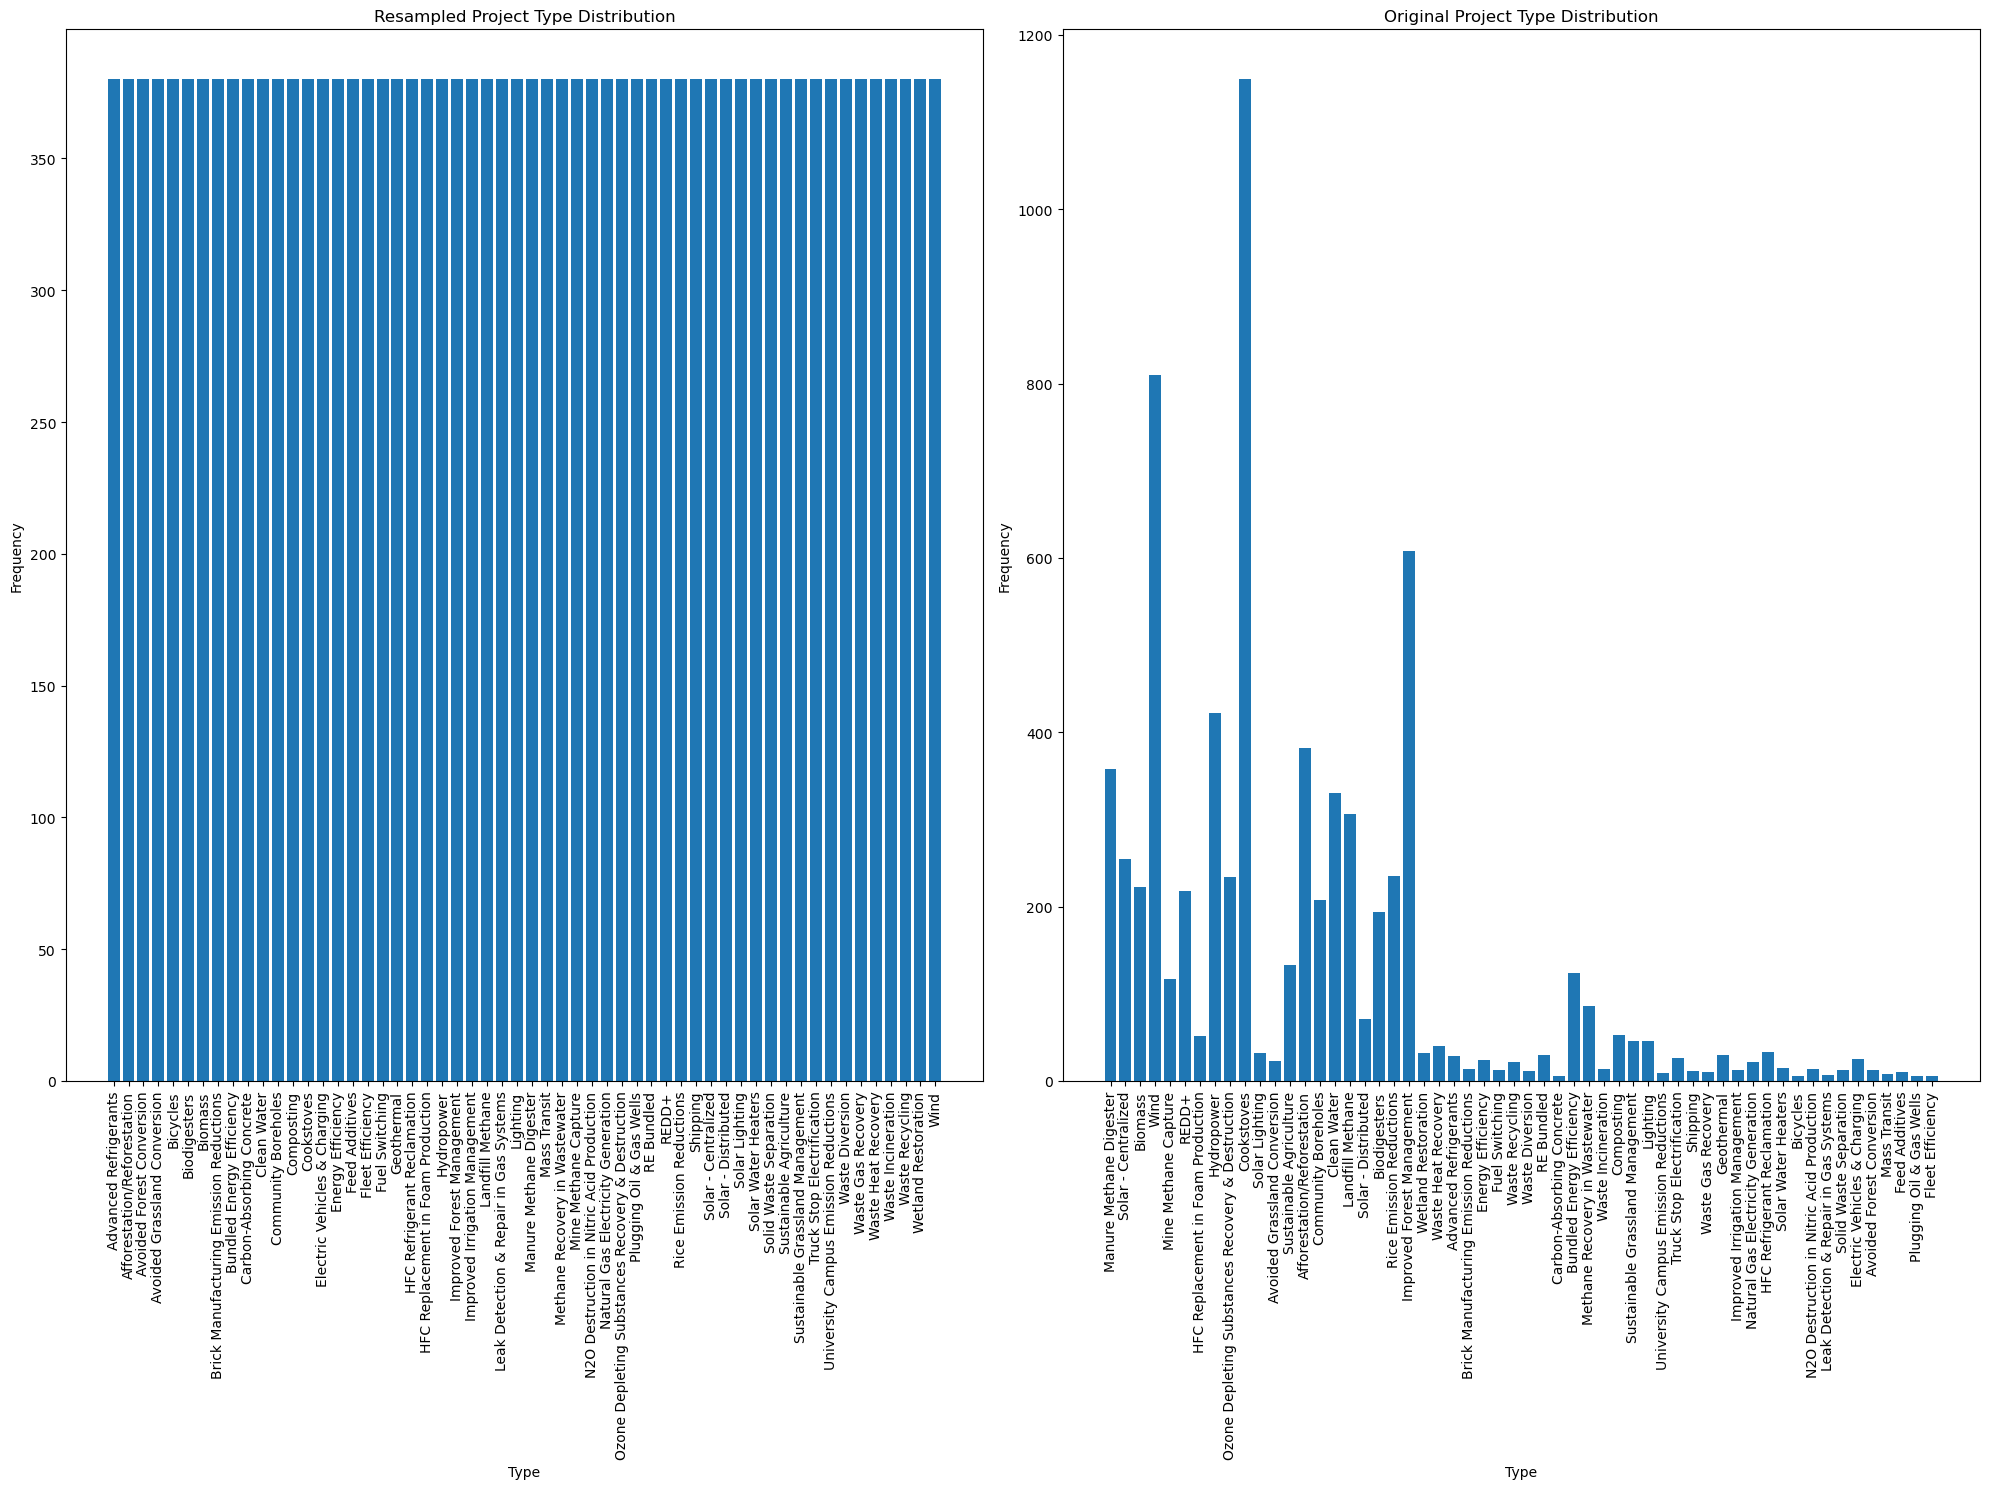

In [55]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

# Resampled class distribution histogram
axes[0].bar(resampledCounter.keys(), resampledCounter.values())
axes[0].set_title('Resampled Project Type Distribution')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(list(resampledCounter.keys()))
axes[0].set_xticklabels(resampledCounter.keys(), rotation=90)

# Original class distribution histogram
axes[1].bar(originalCounter.keys(), originalCounter.values())
axes[1].set_title('Original Project Type Distribution')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(list(originalCounter.keys()))
axes[1].set_xticklabels(originalCounter.keys(), rotation=90)

# Display the histograms
plt.tight_layout()
plt.show()


### Logistic Regression

In [56]:
# Define the logistic regression model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Fit the logistic regression model on the resampled data
logistic_regression.fit(X_resampled_combined, y_resampled)

# Make predictions on the val data

X_val_transformed = preprocessor.transform(X_val)
y_pred = logistic_regression.predict(X_val_transformed)

# Evaluate the model and get the classification report
report = classification_report(Y_val, y_pred, output_dict=True)

# Convert the classification report to a DataFrame for a tabular format
report_df = pd.DataFrame(report).transpose()

# Display the classification report table
report_df

/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,precision,recall,f1-score,support
Advanced Refrigerants,1.000000,1.000000,1.000000,3.000000
Afforestation/Reforestation,1.000000,0.947368,0.972973,38.000000
Avoided Forest Conversion,1.000000,1.000000,1.000000,1.000000
Avoided Grassland Conversion,1.000000,1.000000,1.000000,2.000000
Bicycles,1.000000,1.000000,1.000000,1.000000
Biodigesters,1.000000,0.894737,0.944444,19.000000
Biomass,0.678571,0.863636,0.760000,22.000000
Brick Manufacturing Emission Reductions,1.000000,1.000000,1.000000,1.000000
Bundled Energy Efficiency,0.909091,0.833333,0.869565,12.000000
Carbon-Absorbing Concrete,0.000000,0.000000,0.000000,1.000000


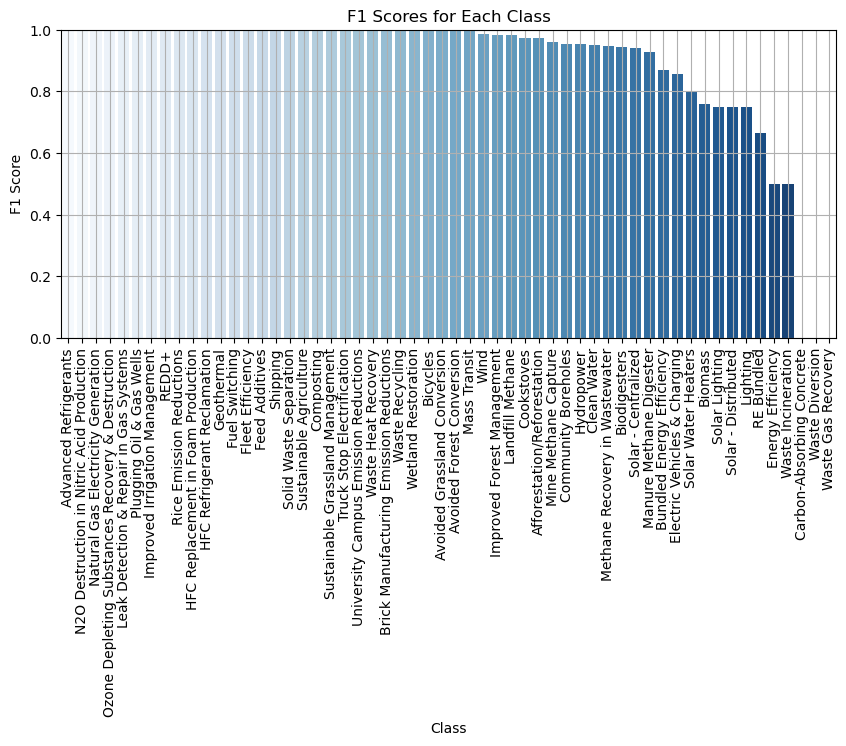

In [57]:
import seaborn as sns
# Extract F1 scores from the classification report
f1_scores = {key: value['f1-score'] for key, value in report.items() if key not in ('accuracy', 'macro avg', 'weighted avg')}

# Convert the F1 scores to a DataFrame for plotting
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Class', 'F1 Score'])

# Sort the DataFrame by F1 Score in ascending order
f1_df = f1_df.sort_values(by='F1 Score', ascending = False)

# Plot the F1 scores
plt.figure(figsize=(10, 4))
sns.barplot(x='Class', y='F1 Score', data=f1_df, palette='Blues')
plt.title('F1 Scores for Each Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.grid(True)
plt.show()

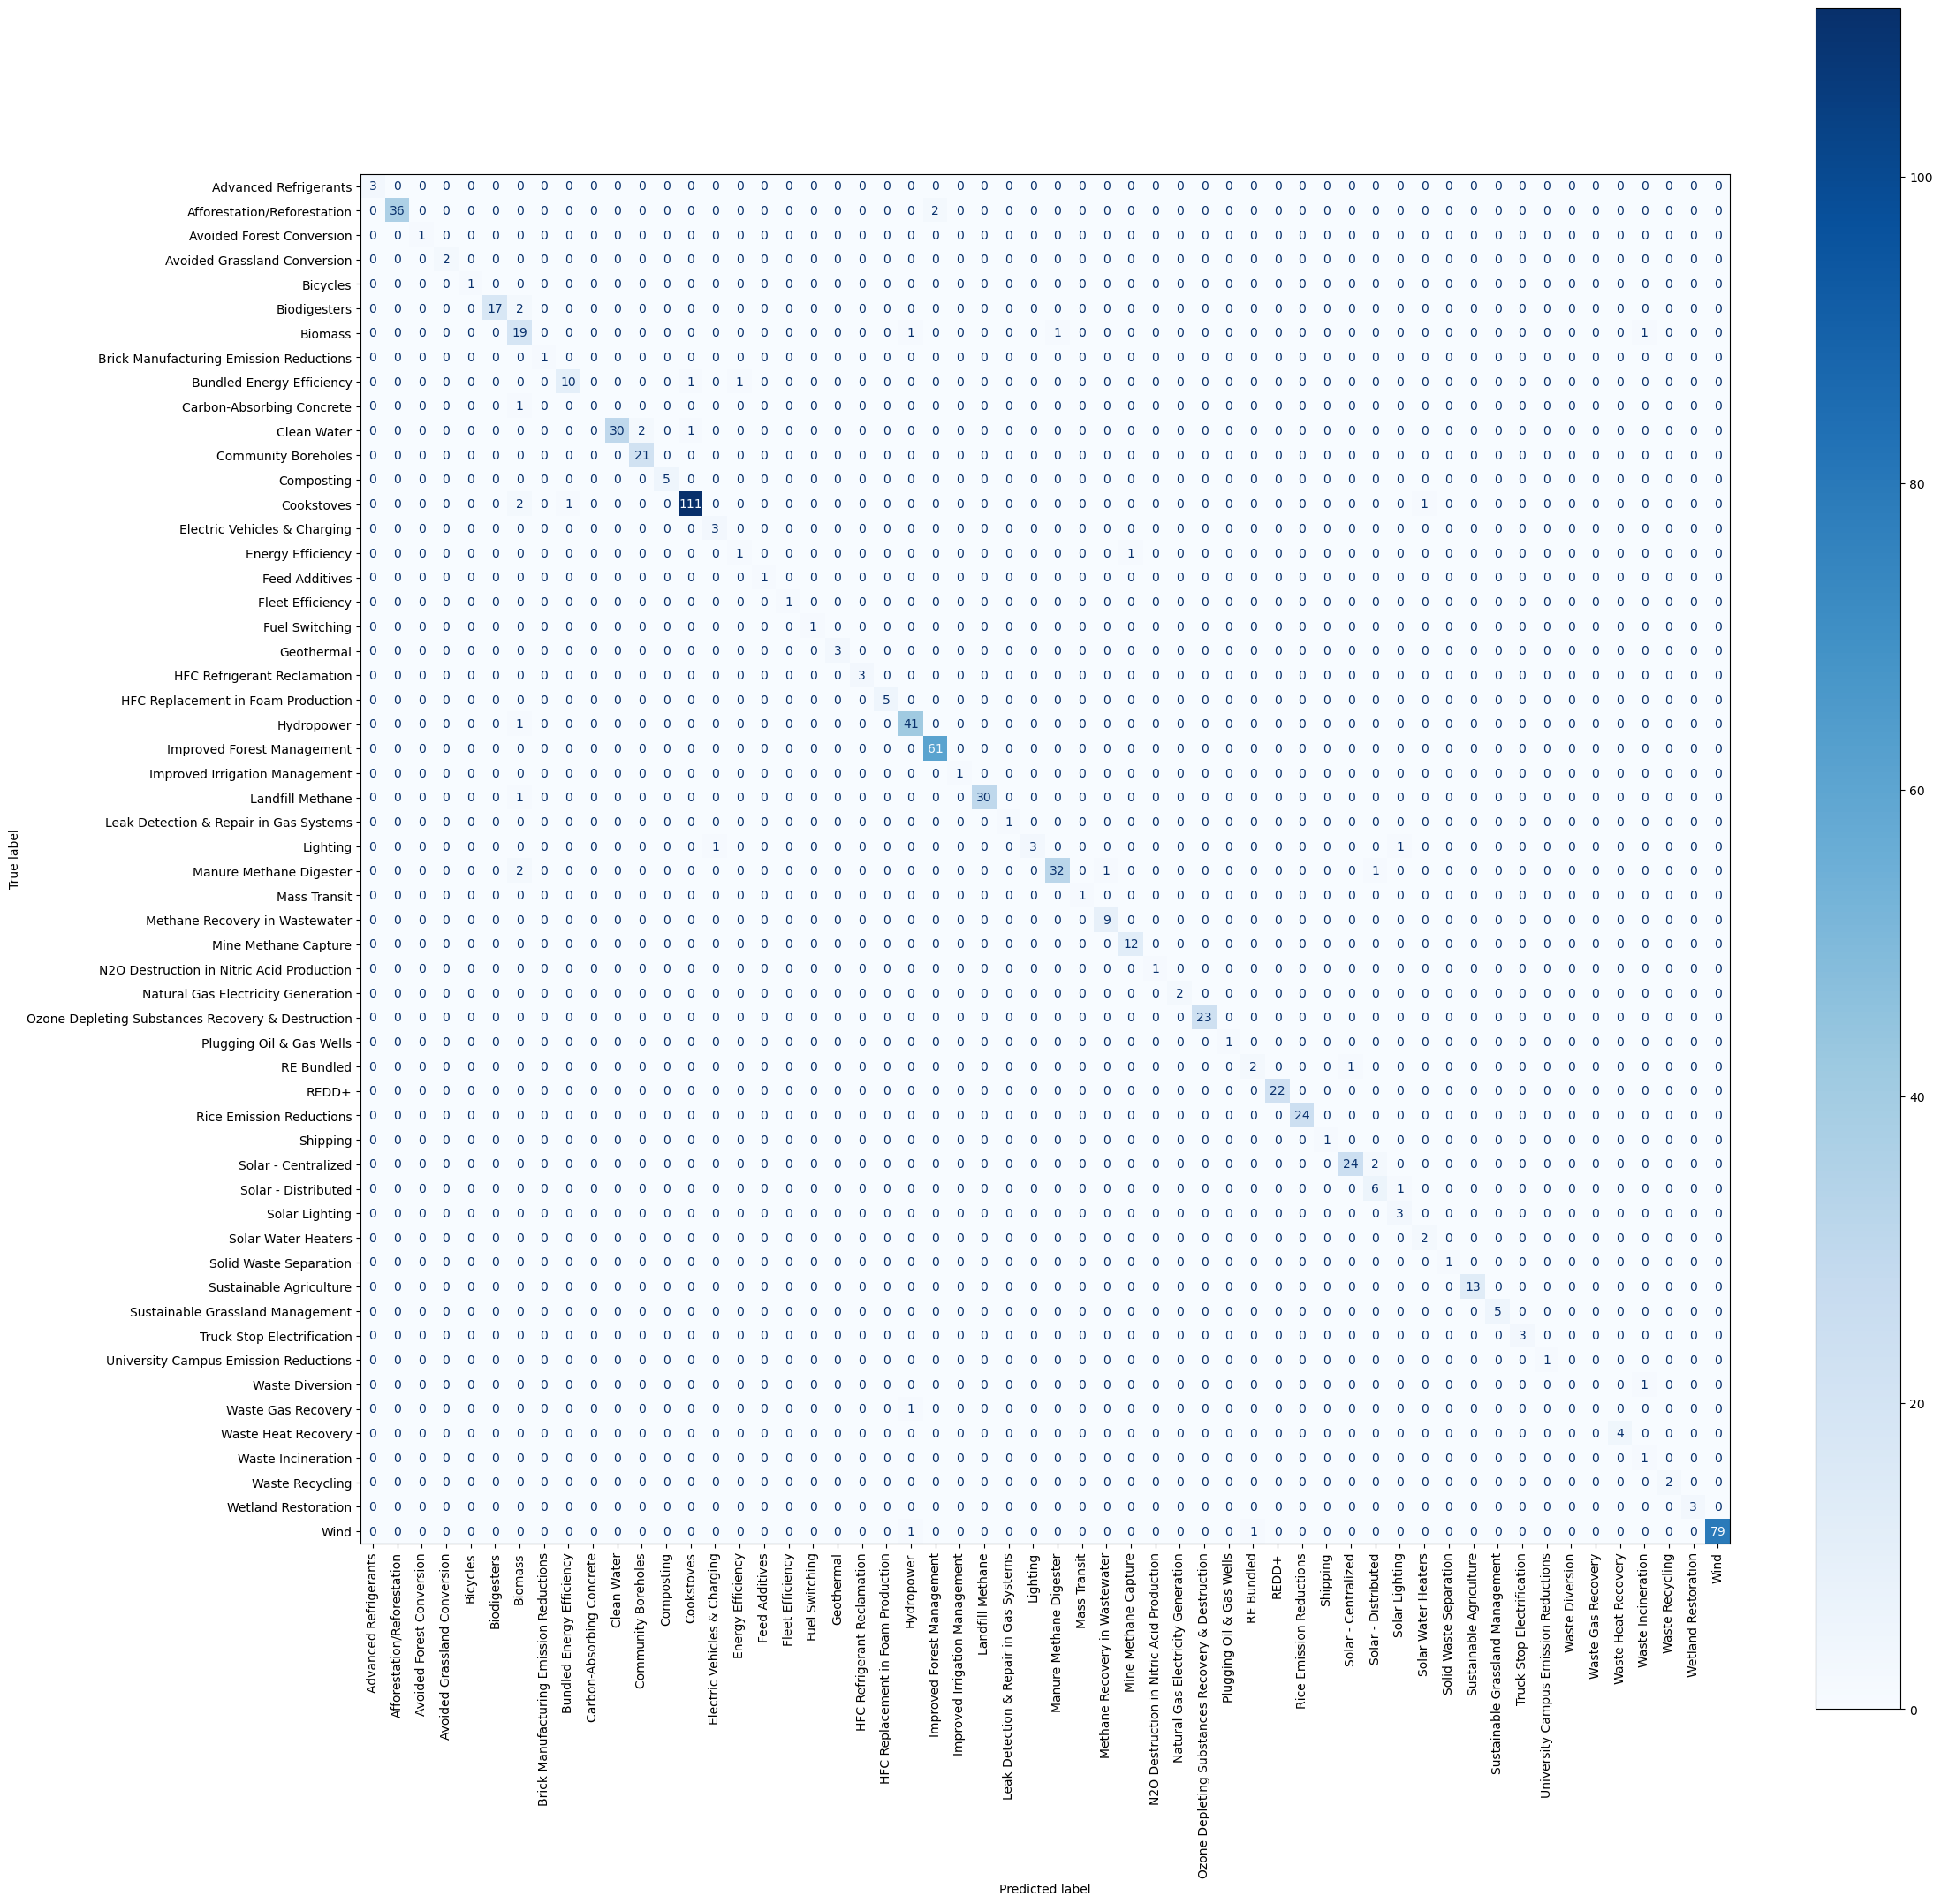

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Generate the confusion matrix
cm = confusion_matrix(Y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_regression.classes_)
fig, ax = plt.subplots(figsize=(25, 25))  
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=90)  # Rotate the x-axis labels if they overlap
plt.show()